In [25]:
# Prepare network data

import numpy as np
import pandas as pd

import datetime as dt
import time

import geopandas as gp
from geopandas import sjoin
import shapely as shp
from shapely.geometry import Point
import fiona as fio
from fiona.crs import from_epsg

import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# pull turnstile data

#mta_2016_wkdy_avg = pd.read_csv('data/mta_2016_weekday_avg')
#mta_2016_mrush_avg = pd.read_csv('data/mta_2016_morn_rush_avg')

In [27]:
# get rid of those weird columns

#mta_2016_wkdy_avg.drop(['Unnamed: 0'],axis=1,inplace=True)
#mta_2016_mrush_avg.drop(['Unnamed: 0'],axis=1,inplace=True)

In [ ]:
#mta_2016_wkdy_avg.head(4)

In [ ]:
#mta_2016_mrush_avg.head(4)

### Using CTPP Data now, not LEHD.

### Ignore below... will change or point to different script...

In [30]:
# pull O-D data

od = pd.read_csv('ny_od_main_JT05_2014.csv')

In [31]:
# trim and convert geos to strings so we can break them up to Boroughs, Tracts, Blocks, etc.

od.rename(columns={'S000':'jobs'},inplace=True)
od_cut = od[['h_geocode','w_geocode','jobs']]

od_cut['home_geo'] = od_cut['h_geocode'].astype(str)
od_cut['work_geo'] = od_cut['w_geocode'].astype(str)

od_cut.drop(['h_geocode','w_geocode'], axis=1,inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [32]:
hm_st = []
hm_boro_fips = []
hm_trk = []
hm_blk=[]

hm_st = od_cut['home_geo'].str[:2]
hm_boro_fips = od_cut['home_geo'].str[2:5]
hm_trk = od_cut['home_geo'].str[5:11]
hm_blk = od_cut['home_geo'].str[-4:]

In [33]:
od_cut['home_st'] = hm_st
od_cut['home_boro_fips'] = hm_boro_fips
od_cut['home_tract'] = hm_trk
od_cut['home_block'] = hm_blk

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [34]:
wk_st = []
wk_boro_fips = []
wk_trk = []
wk_blk=[]

wk_st = od_cut['work_geo'].str[:2]
wk_boro_fips = od_cut['work_geo'].str[2:5]
wk_trk = od_cut['work_geo'].str[5:11]
wk_blk = od_cut['work_geo'].str[-4:]

In [35]:
od_cut['work_st'] = wk_st
od_cut['work_boro_fips'] = wk_boro_fips
od_cut['work_tract'] = wk_trk
od_cut['work_block'] = wk_blk

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

In [36]:
# keep only NYC O-D
# revisit in case we need commuters outside the city

od2 = od_cut[(od_cut['home_boro_fips'] == '005') |
             (od_cut['home_boro_fips'] == '061') | 
             (od_cut['home_boro_fips'] == '081') |
             (od_cut['home_boro_fips'] == '047')]
             
od_nyc = od2[(od2['work_boro_fips'] == '005') |
             (od2['work_boro_fips'] == '061') | 
             (od2['work_boro_fips'] == '081') |
             (od2['work_boro_fips'] == '047')]

# 005 - Bronx
# 047 - Kings (Brooklyn)
# 061 - New York (Manhattan)
# 081 - Queens
# 085 - Richmond (Staten Island) ---- not included

In [39]:
od_nyc.head(3)

,jobs,home_geo,work_geo,home_st,home_boro_fips,home_tract,home_block,work_st,work_boro_fips,work_tract,work_block
0,1,360050001001000,360470520002008,36,005,000100,1000,36,047,052000,2008
1,1,360050002001000,360610031001014,36,005,000200,1000,36,061,003100,1014
2,1,360050002002000,360810853003000,36,005,000200,2000,36,081,085300,3000


In [40]:
od_nyc.sort_values(by='home_geo',inplace=True)
od_nyc.reset_index(drop=True,inplace=True)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [41]:
# pull nyc shapefiles

blocks_shp_nyc = gp.read_file('nycb2010_17b/nycb2010.shp')

In [42]:
blocks_shp_nyc["lon"] = blocks_shp_nyc.centroid.map(lambda p: p.x)
blocks_shp_nyc["lat"] = blocks_shp_nyc.centroid.map(lambda p: p.y)

In [43]:
blocks_shp_nyc.head(2)

,BCTCB2010,BoroCode,BoroName,CB2010,CT2010,Shape_Area,Shape_Leng,geometry,lon,lat
0,50009001000,5,Staten Island,1000,000900,244589.603884,2508.948115,"POLYGON ((962269.1260375977 173705.5001831055,...",961884.615019,173941.733904
1,50020011000,5,Staten Island,1000,002001,111006.286826,1345.886422,"POLYGON ((964642.2676391602 161835.2651977539,...",964403.711675,161848.999102


In [44]:
# pull netork nodes 

ndata = pd.read_csv("data/nyc_subway_stations_with_lines.csv")

In [45]:
geometry = [Point(xy) for xy in zip(ndata['stop_lon'], ndata['stop_lat'])]
crs = {'init': 'epsg:4326', 'no_defs': True}
#    crs = {'init': 'epsg:2263', 'no_defs': True}
ndata_g = gp.GeoDataFrame(ndata, crs=crs, geometry=geometry)       
ndata_g = ndata_g.to_crs(epsg=2263)
ndata_g.drop(['stop_lon','stop_lat','Unnamed: 0'],axis=1,inplace=True)
ndata_g["stop_lon"] = ndata_g.centroid.map(lambda p: p.x)
ndata_g["stop_lat"] = ndata_g.centroid.map(lambda p: p.y)

In [46]:
ndata_g.head(3)

,stop_id,stop_name,Borough,Daytime Routes,geometry,stop_lon,stop_lat
0,101,Van Cortlandt Park - 242 St,Bx,1,POINT (1012291.155985304 263271.2080455146),1.012291e+06,263271.208046
1,103,238 St,Bx,1,POINT (1011660.704076381 261601.4418330777),1.011661e+06,261601.441833
2,104,231 St,Bx,1,POINT (1010566.908281725 259483.0473639019),1.010567e+06,259483.047364


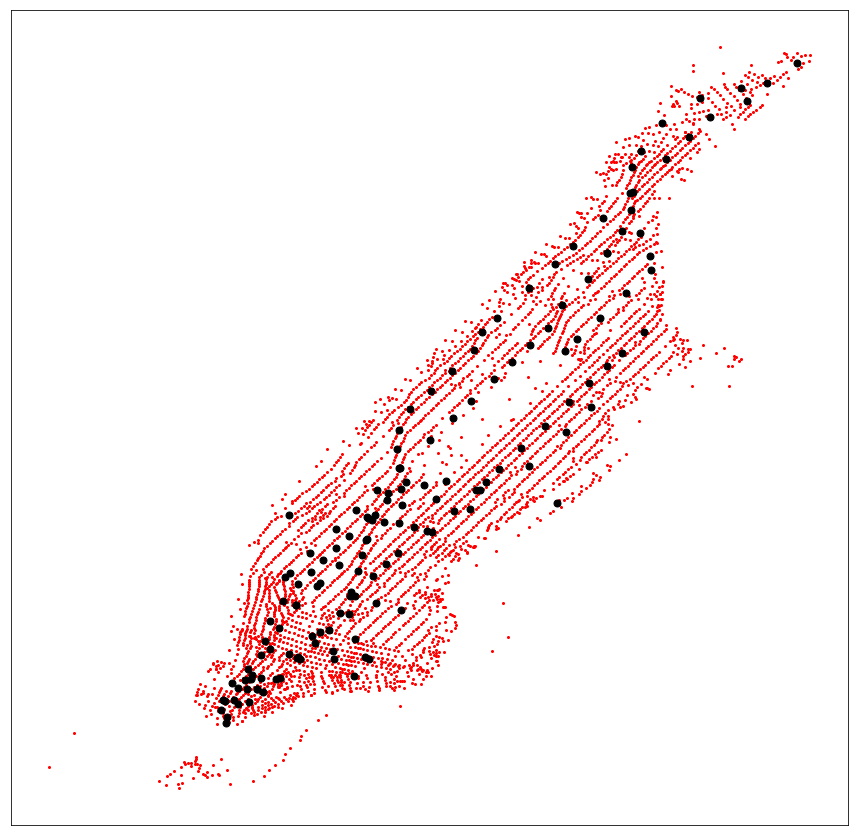

In [47]:
# just to get some context re block centroids & stations

f, ax = plt.subplots(figsize=(15,15))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
blocks_shp_nyc[blocks_shp_nyc['BoroCode'] == '1'].geometry.centroid.plot(color='red',ax=ax)
ndata_g[ndata_g['Borough'] == 'M'].geometry.plot(color='black',markersize = 7, ax=ax)

In [49]:
### Now using CTTP, not LEHD.

# write to files

# od_nyc.to_csv('data/od_nyc.csv')
# blocks_shp_nyc.to_csv('data/blocks_nyc.csv')
# ndata_g.to_csv('data/ndata_g.csv')

In [ ]:
##### No longer


# Need to pair O-D's with shortest subway paths while minimizing walking time from block centroid to/from associated
# node/stations.  (That way we allocate commute weight (as a proxy for passenger flow)).  Then incorporate turnstile
# activity to estimate to and from where people are going.  Thus far, assuming a 4-hour period.
# ...May need further adjustments to reconcile for any network imbalance.  

# To be continued here or separate notebook.
